# A Cappella Classifier Demo

This notebook loads my audio preprocessing utilities, uploads the simple classifier trained on my custome dataset, and provides helper functions to **classify and visualize new audio clips** as a cappella or non-a cappella.

In [4]:
# Clone the repo if not already present
!git clone https://github.com/gamendoza26/acapella-detector.git || true

# Move into repo
%cd acapella-detector

Cloning into 'acapella-detector'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 126 (delta 57), reused 49 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (126/126), 646.65 KiB | 12.44 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/acapella-detector/acapella-detector


In [5]:
# Acappella Detector Demo - Inference Only

import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import joblib

try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

CWD = Path.cwd()
if (CWD / "models").exists():
    REPO_ROOT = CWD
else:
    REPO_ROOT = CWD.parent

MODEL_DIR = REPO_ROOT / "models"
SRC_DIR = REPO_ROOT / "src"

print("Current working directory:", CWD)
print("Repo root:", REPO_ROOT)
print("Model dir:", MODEL_DIR)

import sys
sys.path.append(str(SRC_DIR))

from preprocessing.audio import load_and_process_audio

CLASS_NAMES = {0: "non_acapella", 1: "acapella"}


Current working directory: /content/acapella-detector/acapella-detector
Repo root: /content/acapella-detector/acapella-detector
Model dir: /content/acapella-detector/acapella-detector/models


In [6]:
# Load pretrained logistic regression model and scaler

clf_path = MODEL_DIR / "acapella_logreg.pkl"
scaler_path = MODEL_DIR / "acapella_scaler.pkl"

print("Loading classifier from:", clf_path)
print("Loading scaler from:", scaler_path)

clf = joblib.load(clf_path)
scaler = joblib.load(scaler_path)

print("Model and scaler loaded successfully.")

Loading classifier from: /content/acapella-detector/acapella-detector/models/acapella_logreg.pkl
Loading scaler from: /content/acapella-detector/acapella-detector/models/acapella_scaler.pkl
Model and scaler loaded successfully.


In [19]:
def spectrogram_to_feature(S_db):
    """
    Collapse a mel-spectrogram (n_mels, time) into a 1D feature vector
    by averaging over the time axis.
    """
    return S_db.mean(axis=1)


def clip_to_feature(path):
    """
    Load an audio clip, convert to mel-spectrogram (using your
    training-time preprocessing), then to a scaled feature vector
    ready for the classifier.
    """
    S_db = load_and_process_audio(str(path))
    feat = spectrogram_to_feature(S_db)
    feat = feat.reshape(1, -1)
    feat_scaled = scaler.transform(feat)
    return feat_scaled, S_db


def classify_clip(path, show_spectrogram=True):
    """
    Run the trained classifier on one audio file and optionally
    display its mel-spectrogram.
    """
    feat_scaled, S_db = clip_to_feature(path)
    probs = clf.predict_proba(feat_scaled)[0]
    pred = int(np.argmax(probs))
    label = CLASS_NAMES[pred]
    confidence = probs[pred]

    print(f"File: {path}")
    print(f"Predicted label: {label}")
    print(f"Confidence: {confidence:.3f}")

    if show_spectrogram:
        plt.figure(figsize=(8, 3))
        librosa.display.specshow(S_db, y_axis="mel", x_axis=None)
        plt.colorbar(format="%+2.0f dB")
        plt.title(f"Mel spectrogram ({label}, p={confidence:.2f})")
        plt.tight_layout()
        plt.show()

    return label, confidence


Upload an audio file (.wav, .mp3, .m4a, .flac):


Saving forget_you_nonacapella_demo.m4a to forget_you_nonacapella_demo (1).m4a

--- Classifying uploaded file ---
File: forget_you_nonacapella_demo (1).m4a
Predicted label: non_acapella
Confidence: 1.000


/content/acapella-detector/acapella-detector/src/preprocessing/audio.py:11: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


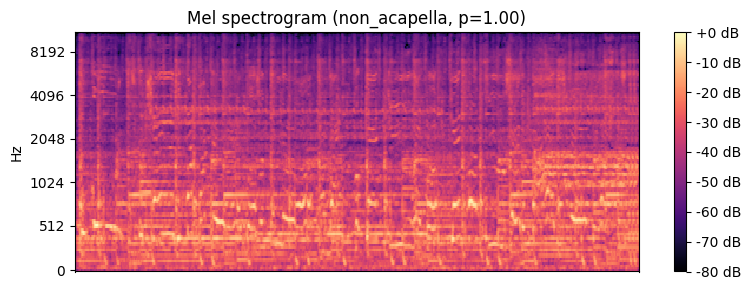

In [36]:
if not IN_COLAB:
    print("This upload widget is intended for Google Colab.")
else:
    print("Upload an audio file (.wav, .mp3, .m4a, .flac):")
    uploaded = files.upload()

    for fname in uploaded.keys():
        print("\n--- Classifying uploaded file ---")
        label, confidence = classify_clip(fname, show_spectrogram=True)
